In [41]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
data = pd.read_excel('CocaCola.xlsx')
data.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


<AxesSubplot: >

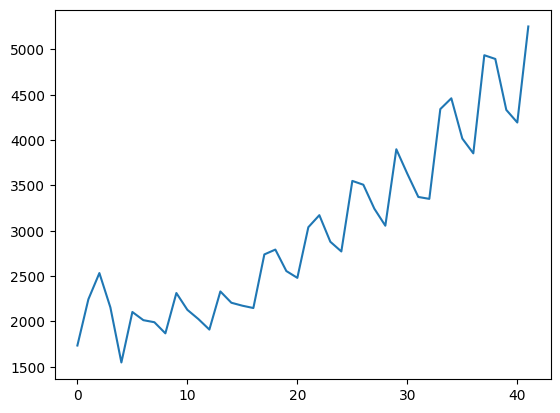

In [43]:
data['Sales'].plot()

In [44]:
# linear upward trend
# change non-stationary data into stationary data
# data.head()

In [45]:
data.dtypes

Quarter     object
Sales      float64
dtype: object

In [46]:
data["Year"] = data['Quarter'].str[-2:]
data["Quarter"] = data['Quarter'].str[:2]
data['t'] = data.index+1
data['t_square'] = data['t']**2
data['log_sales'] = np.log(data['Sales'])
data = pd.get_dummies(data=data,columns=['Quarter'])
#data['Q1'] = data['Quarter_Q1']
#data['Q2'] = data['Quarter_Q2']
#data['Q3'] = data['Quarter_Q3']
#data['Q4'] = data['Quarter_Q4']
data.head()

,Sales,Year,t,t_square,log_sales,Quarter_Q1,Quarter_Q2,Quarter_Q3,Quarter_Q4
0,1734.827000,86,1,1,7.458663,1,0,0,0
1,2244.960999,86,2,4,7.716443,0,1,0,0
2,2533.804993,86,3,9,7.837477,0,0,1,0
3,2154.962997,86,4,16,7.675529,0,0,0,1
4,1547.818996,87,5,25,7.344602,1,0,0,0


In [47]:
data.shape

(42, 9)

In [48]:
data.dtypes

Sales         float64
Year           object
t               int64
t_square        int64
log_sales     float64
Quarter_Q1      uint8
Quarter_Q2      uint8
Quarter_Q3      uint8
Quarter_Q4      uint8
dtype: object

<AxesSubplot: xlabel='Year', ylabel='Sales'>

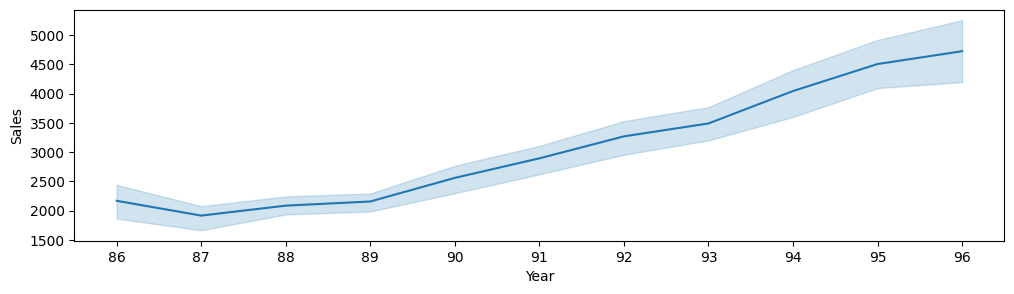

In [49]:
plt.figure(figsize=(12,3))
sns.lineplot(data=data,x='Year',y='Sales')

### Data Splitting

In [50]:
train = data.head(30)
test = data.tail(12)

### Import error function and statistics model

In [51]:
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

### Building different models

#### Linear Model
##### $Y_t = \beta_o+\beta_1t+\epsilon$ 

In [52]:
linear_model = smf.ols('Sales~t',data=data).fit()
pred_linear = pd.Series(linear_model.predict(pd.DataFrame(test['t'])))
rmse_linear = np.sqrt(mean_squared_error(test['Sales'],pred_linear))
rmse_linear

449.799622612296

#### Exponential model
##### $Log(Y_t) = \beta_0+\beta_1t+\epsilon$

In [53]:
exp_model = smf.ols('log_sales~t',data=train).fit()
pred_exp = pd.Series(exp_model.predict(pd.DataFrame(test['t'])))
rmse_exp = np.sqrt(mean_squared_error(test['log_sales'],pred_exp))
rmse_exp

0.12733341664175737

#### Quadratic model
##### $Y_t = \beta_0+\beta_1t+\beta_2t^2+\epsilon$

In [54]:
quad_model = smf.ols('Sales~t+t_square',data=train).fit()
pred_quad = pd.Series(quad_model.predict(pd.DataFrame(test[['t','t_square']])))
rmse_quad = np.sqrt(mean_squared_error(test['Sales'],pred_quad))
rmse_quad

646.2715428311304

#### Additive seasonality
##### $Y_t = \beta_0+\beta_1D_{jan}+\beta_2D_{Feb}+...+\beta_{11}D_{Nov}+\epsilon$

In [55]:
addsea_model = smf.ols('Sales~Quarter_Q1+Quarter_Q2+Quarter_Q3+Quarter_Q4',data=train).fit()
pred_addsea = pd.Series(addsea_model.predict(pd.DataFrame(test[['Quarter_Q1','Quarter_Q2','Quarter_Q3','Quarter_Q4']])))
rmse_addsea = np.sqrt(mean_squared_error(test['Sales'],pred_addsea))
rmse_addsea

1778.0065467941365

#### Additive Seasonality Quadratic Model
##### $Y_t = \beta_0+\beta_1t+\beta_2t^2+\beta_3D_{Jan}+...+\beta_{13}D_{Nov}+\epsilon$

In [56]:
addSeaQuad_model = smf.ols('Sales~t+t_square+Quarter_Q1+Quarter_Q2+Quarter_Q3+Quarter_Q4',data=train).fit()
pred_addSeaQuad = pd.Series(addSeaQuad_model.predict(pd.DataFrame(test[['t','t_square','Quarter_Q1','Quarter_Q2','Quarter_Q3','Quarter_Q4']])))
rmse_addSeaQuad = np.sqrt(mean_squared_error(test['Sales'],pred_addSeaQuad))
rmse_addSeaQuad

586.0533067871002

### MUltiplicative Seasonality
#### $Log(Y_t) = \beta_0+\beta_1D_{Jan}+\beta_2D_{Feb}+\beta_3D_{Mar}+...+\beta_11D_{Nov}+\epsilon$

In [57]:
mulsea_model = smf.ols('log_sales~Quarter_Q1+Quarter_Q2+Quarter_Q3+Quarter_Q4',data=train).fit()
pred_mulsea = pd.Series(mulsea_model.predict(pd.DataFrame(test[['Quarter_Q1','Quarter_Q2','Quarter_Q3','Quarter_Q4']])))
rmse_mulsea = np.sqrt(mean_squared_error(test['log_sales'],pred_mulsea))
rmse_mulsea

0.547351038173912

### Compare the result

In [58]:
result_data ={"MODEL":pd.Series(['linear','exponential','quadratic','addSea','addSeaQuad','mulSea']),
"RMSE_VAlues":pd.Series([rmse_linear,rmse_exp,rmse_quad,rmse_addsea,rmse_addSeaQuad,rmse_mulsea])}
table_rmse = pd.DataFrame(result_data)
table_rmse.sort_values(["RMSE_VAlues"])

,MODEL,RMSE_VAlues
1,exponential,0.127333
5,mulSea,0.547351
0,linear,449.799623
4,addSeaQuad,586.053307
2,quadratic,646.271543
3,addSea,1778.006547
